In [12]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import squidpy as sq
from skimage import io
from sklearn import preprocessing
from tqdm.notebook import tqdm, trange
import anndata as ad
import cv2

In [2]:
# Import spatial omics library
import athena as ath
from spatialOmics import SpatialOmics

# import default graph builder parameters
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

In [3]:
p_dir = (Path().cwd().parents[0].parents[0]).absolute()
data_dir = p_dir / "09_datasets"
database_dir = (Path().cwd().parents[0]).absolute() / 'data'/ 'raw'
adata_dir = (Path().cwd().parents[0]).absolute() / 'data'/ 'processed'

masks_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'masks'
mask_folder = data_dir / 'exported' / 'foll_masks'
spatial_omics_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics'

# Read all adata

Perform assignment of single-cell to corresponding foll and GC based on centroids location

In [4]:
def is_in_mask(adata, mask, centroids=None, col_name='foll'):
    adata.obs[col_name] = 0
    
    if not centroids:
        centroids = adata.obsm['spatial'].astype(int)
    
    for i in tqdm(np.unique(mask)[1:]):
        # Extract follicle region
        indices_foll = mask[centroids[:,1],centroids[:,0]] == i
        adata.obs[col_name].iloc[indices_foll] = i
    
    return adata

In [5]:
adatas = []
datasets = []

# Loop through data
for (dirpath, dirnames, filenames) in os.walk(database_dir):
    for name in tqdm(sorted(filenames)):
        if 'h5ad' not in name:
            continue
         
        # read adata
        data_name = name.split('.')[0]
        print(f'Processing Data {data_name}')   
        path = os.path.join(dirpath, name)
        
        adata = sc.read_h5ad(path)
        adata.obs['Data'] = data_name
        
        if 'Dataset' in adata.obs:
            for d in adata.obs.Dataset.unique():
                a = adata[adata.obs.Dataset == d]
                adatas.append(a)
                datasets.append(data_name+f'_{d}')
        else:
            adatas.append(adata)
            datasets.append(data_name)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing Data 01
Processing Data 03
Processing Data 05


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing Data 05_v1
Processing Data 07


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processing Data 08


In [6]:
for i, adata in enumerate(adatas):
    data_name = datasets[i]
    new_path = adata_dir / f'{data_name}.h5ad'

    if new_path.exists():
        adata = sc.read_h5ad(new_path)
    else:
        if data_name == '05_v1':
            data_name = '05'
        # Read mask 
        GC_mask_path = mask_folder / f'{data_name}_GC.png'
        foll_mask_path = mask_folder / f'{data_name}_foll.png'

        GC_mask = cv2.imread(str(GC_mask_path), cv2.IMREAD_UNCHANGED)
        foll_mask = cv2.imread(str(foll_mask_path), cv2.IMREAD_UNCHANGED)

        # Assign cell to foll id
        print(adata.obsm['spatial'].max(axis=0), GC_mask.shape)
        adata =  is_in_mask(adata, foll_mask, col_name='Foll')
        adata =  is_in_mask(adata, GC_mask, col_name='GC')

        # Write adata
        adata.write_h5ad(new_path)

    # fig, ax = plt.subplots(figsize=(10,10))
    # sc.pl.spatial(adata[adata.obs.Foll>0], color=['Foll'],spot_size=20, ax=ax)


# Create Spatial omics data from athena

In [7]:
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

def create_spatial(adata, data_name, identifier = 'Foll', masks_folder=masks_folder):
    if data_name == '05_v1':
        data_name_mask = '05'
    mask_path = masks_folder / f'{data_name_mask}.hdf5'
    
    foll_ids = sorted(adata[adata.obs.Foll>0].obs['Foll'].unique())

    # Create unique follicle region
    spadata = SpatialOmics()
    spl = pd.DataFrame({identifier:  foll_ids})
    spadata.spl = spl

    # Create unique follicle ROI
    spadata_roi = SpatialOmics()
    spl = pd.DataFrame({identifier:  foll_ids})
    spadata_roi.spl = spl

    min_rows = []
    max_rows = []
    min_cols = []
    max_cols = []
    cell_counts = []

    for foll in tqdm(foll_ids):
        adata_subset = adata[adata.obs[identifier] == foll, :]
        obs = adata_subset.obs.copy()
        obs.index = obs.Cell.tolist()
        obs['x'] = adata_subset.obsm['spatial'][:,0]
        obs['y'] = adata_subset.obsm['spatial'][:,1]
        spadata.obs[foll] = obs
        spadata.X[foll] = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names.tolist(), index=obs.Cell.tolist())
        spadata.var[foll] = adata_subset.var

        # Get mask from follicle info
        w_min, h_min=np.floor(adata_subset.obsm['spatial'].min(axis=0)).astype(int)
        w_max, h_max=np.ceil(adata_subset.obsm['spatial'].max(axis=0)).astype(int)

        min_rows.append(h_min)
        min_cols.append(w_min)
        max_rows.append(h_max)
        max_cols.append(w_max)
        cell_counts.append(len(adata_subset))
        
        with h5py.File(mask_path, "r") as f:
            mask = f['mask'][h_min:h_max, w_min:w_max]
            
        cell_id = np.unique(obs.Cell.tolist())
        mask = np.where(np.isin(mask, cell_id), mask, 0)
        spadata.masks[foll] = {'cellmasks': mask}
        ath.pp.extract_centroids(spadata, foll, mask_key='cellmasks')

        with h5py.File(mask_path, "r") as f:
            mask = f['mask'][h_min:h_max, w_min:w_max]
        
        cell_id = np.unique(mask)
        adata_subset = adata[adata.obs.Cell.isin(cell_id), :]
        obs = adata_subset.obs.copy()
        obs.index = obs.Cell.tolist()
        obs['x_whole'] = adata_subset.obsm['spatial'][:,0]
        obs['y_whole'] = adata_subset.obsm['spatial'][:,1]
        spadata_roi.obs[foll] = obs
        spadata_roi.X[foll] = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names.tolist(), index=obs.Cell.tolist())
        spadata_roi.var[foll] = adata_subset.var
        spadata_roi.masks[foll] = {'cellmasks': mask}
        ath.pp.extract_centroids(spadata_roi, foll, mask_key='cellmasks')

    spadata.spl['min_row'] = min_rows
    spadata.spl['max_row'] = max_rows
    spadata.spl['min_col'] = min_cols
    spadata.spl['max_col'] = max_cols
    spadata.spl['cell_count'] = cell_counts

    spadata_roi.spl['min_row'] = min_rows
    spadata_roi.spl['max_row'] = max_rows
    spadata_roi.spl['min_col'] = min_cols
    spadata_roi.spl['max_col'] = max_cols
    
    return spadata, spadata_roi

In [8]:
adatas = [] 

for i, data_name in enumerate(datasets):
    new_path = adata_dir / f'{data_name}.h5ad'
    adata = sc.read_h5ad(new_path)
    adatas.append(adata)


In [9]:
for i, adata in enumerate(adatas):
    data_name = datasets[i]
    print(data_name)
    spatial_path = spatial_omics_folder / f'{data_name}.hdf5'
    spatial_roi_path = spatial_omics_folder / f'{data_name}_roi.hdf5'
    
    if spatial_path.exists():
        continue
    
    # Get spadata
    spadata, spadata_roi = create_spatial(adata, data_name)
    
    # Save spadatas
    spadata.to_h5py(spatial_path)
    spadata_roi.to_h5py(spatial_roi_path)


01
03
05
05_v1
07_A11
07_A18
07_A21
07_A22
07_A6
07_A8
07_T18
07_T22
07_T3
07_T5
07_T6
07_T8
08


In [ ]:
graph_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics_graph'

# Contact graph
config = GRAPH_BUILDER_DEFAULT_PARAMS['contact']
config['builder_params']['radius'] = 2 # set parameter k

for i, adata in enumerate(adatas):
    data_name = datasets[i]
    print(data_name)
    spatial_path = spatial_omics_folder / f'{data_name}.hdf5'
    spatial_roi_path = spatial_omics_folder / f'{data_name}_roi.hdf5'
    spadata = SpatialOmics.from_h5py(spatial_path)
    spadata_roi = SpatialOmics.from_h5py(spatial_roi_path)
    
    spatial_path = graph_folder / f'{data_name}.hdf5'
    spatial_roi_path = graph_folder / f'{data_name}_roi.hdf5'
    
    if spatial_path.exists():
        continue
        
    # Create contact graph per foll
    for foll in tqdm(spadata_roi.spl.Foll.unique()):
        foll = str(foll)
        ath.graph.build_graph(spadata, foll, builder_type='contact', mask_key='cellmasks', 
                          coordinate_keys=('x', 'y'), config=config)
        ath.graph.build_graph(spadata_roi, foll, builder_type='contact', mask_key='cellmasks', 
                          coordinate_keys=('x', 'y'), config=config)
    # Save spadatas
    spadata.to_h5py(spatial_path)
    spadata_roi.to_h5py(spatial_roi_path)

01
03
05
05_v1


 96%|█████████████████████████████████████████████████████████████████████████   | 14128/14697 [10:51<00:25, 21.98it/s]

1


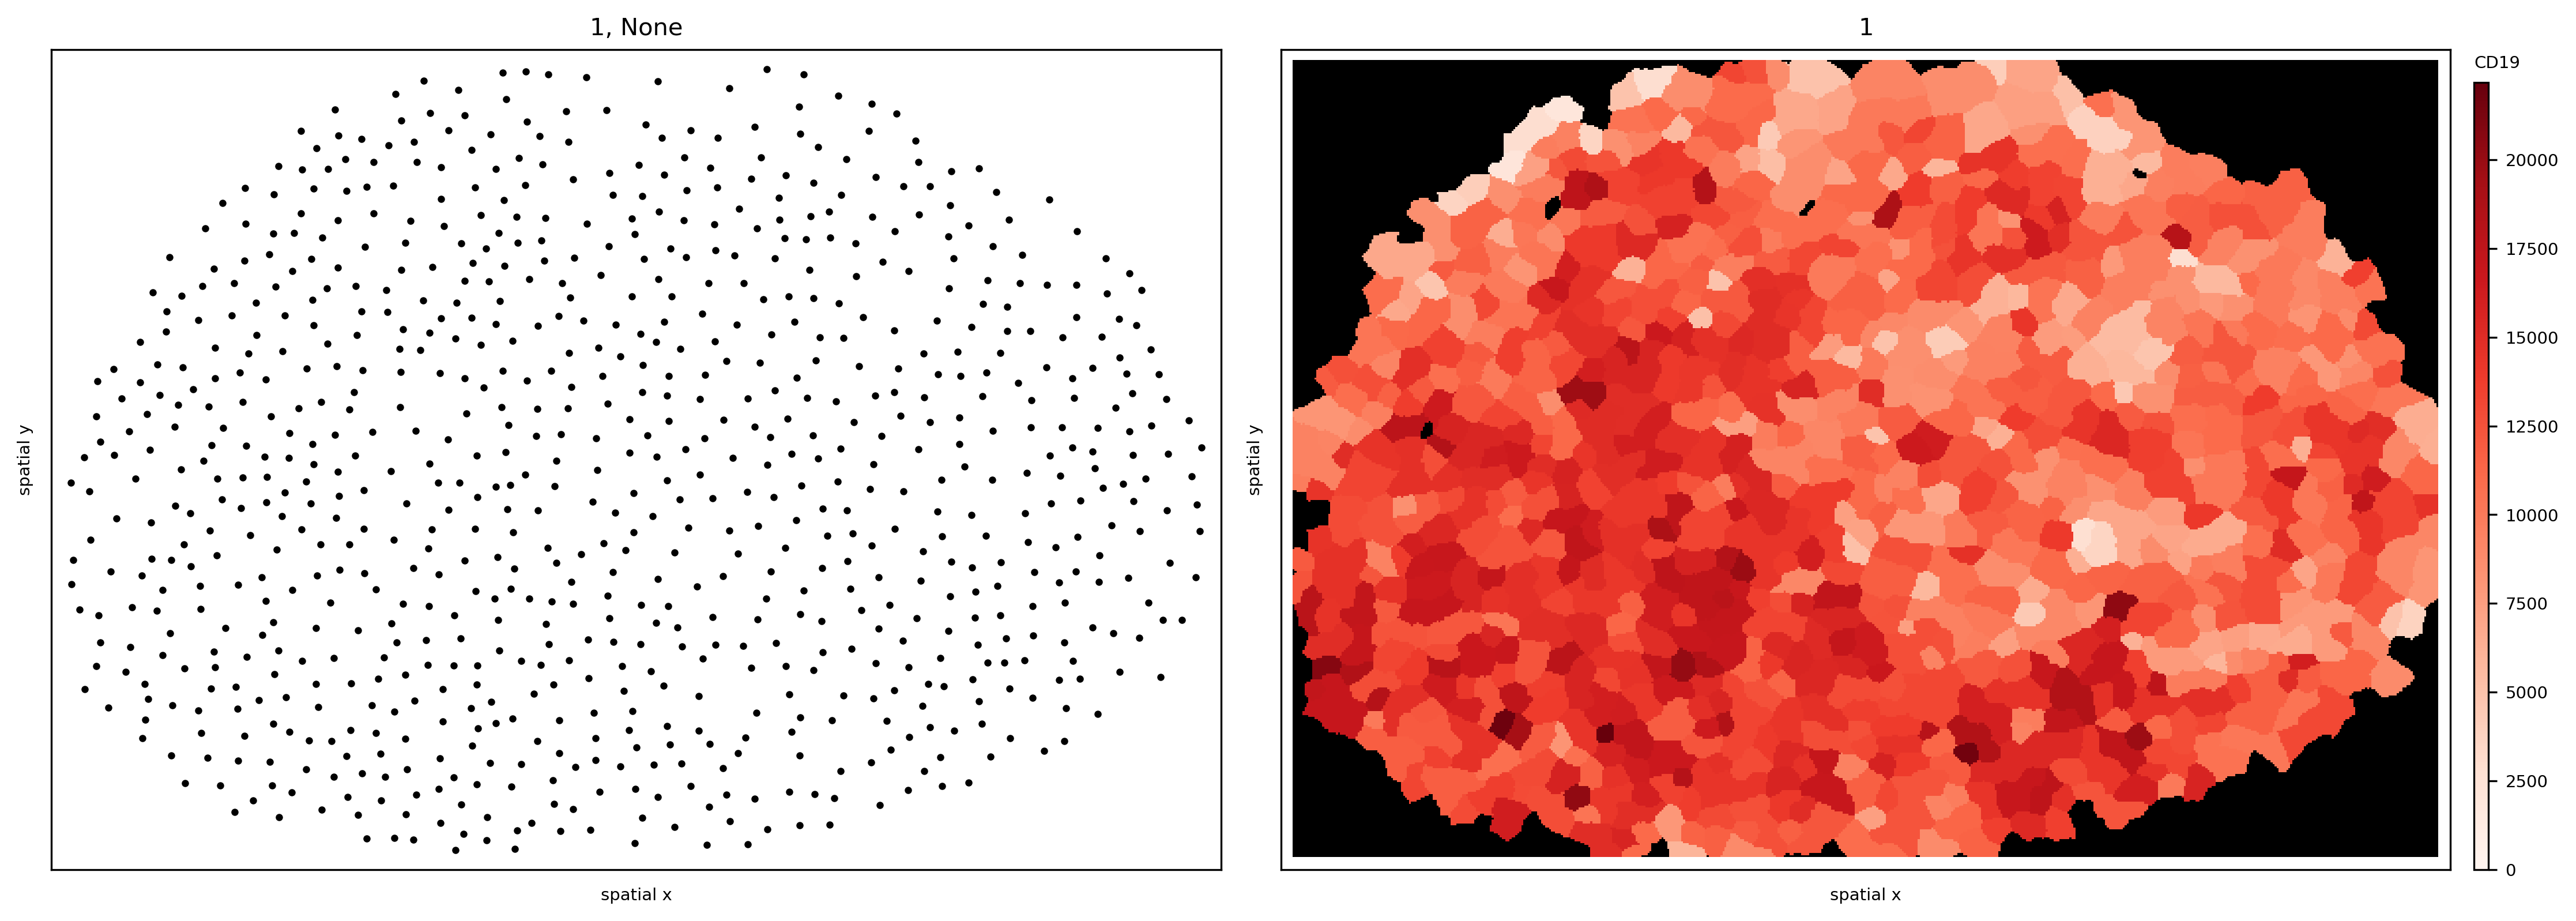

In [76]:
for foll in spadata_roi.spl.Foll.unique():
    print(foll)
    foll = str(foll)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
    ath.pl.spatial(spadata, str(foll), None, ax=axs.flat[0])
    ath.pl.spatial(spadata, str(foll), 'CD19', mode='mask', ax=axs.flat[1], background_color='black')
    break

In [68]:
# Contact graph
config = GRAPH_BUILDER_DEFAULT_PARAMS['contact']
config['builder_params']['radius'] = 2 # set parameter k

ath.graph.build_graph(spadata, foll, builder_type='contact', mask_key='cellmasks', 
                      coordinate_keys=('x', 'y'), config=config)

100%|███████████████████████████████████████████████████████████████████████████████| 670/670 [00:02<00:00, 227.25it/s]


In [69]:
spadata.G[foll]

{'contact': <networkx.classes.graph.Graph at 0x2a0d3dcd120>}

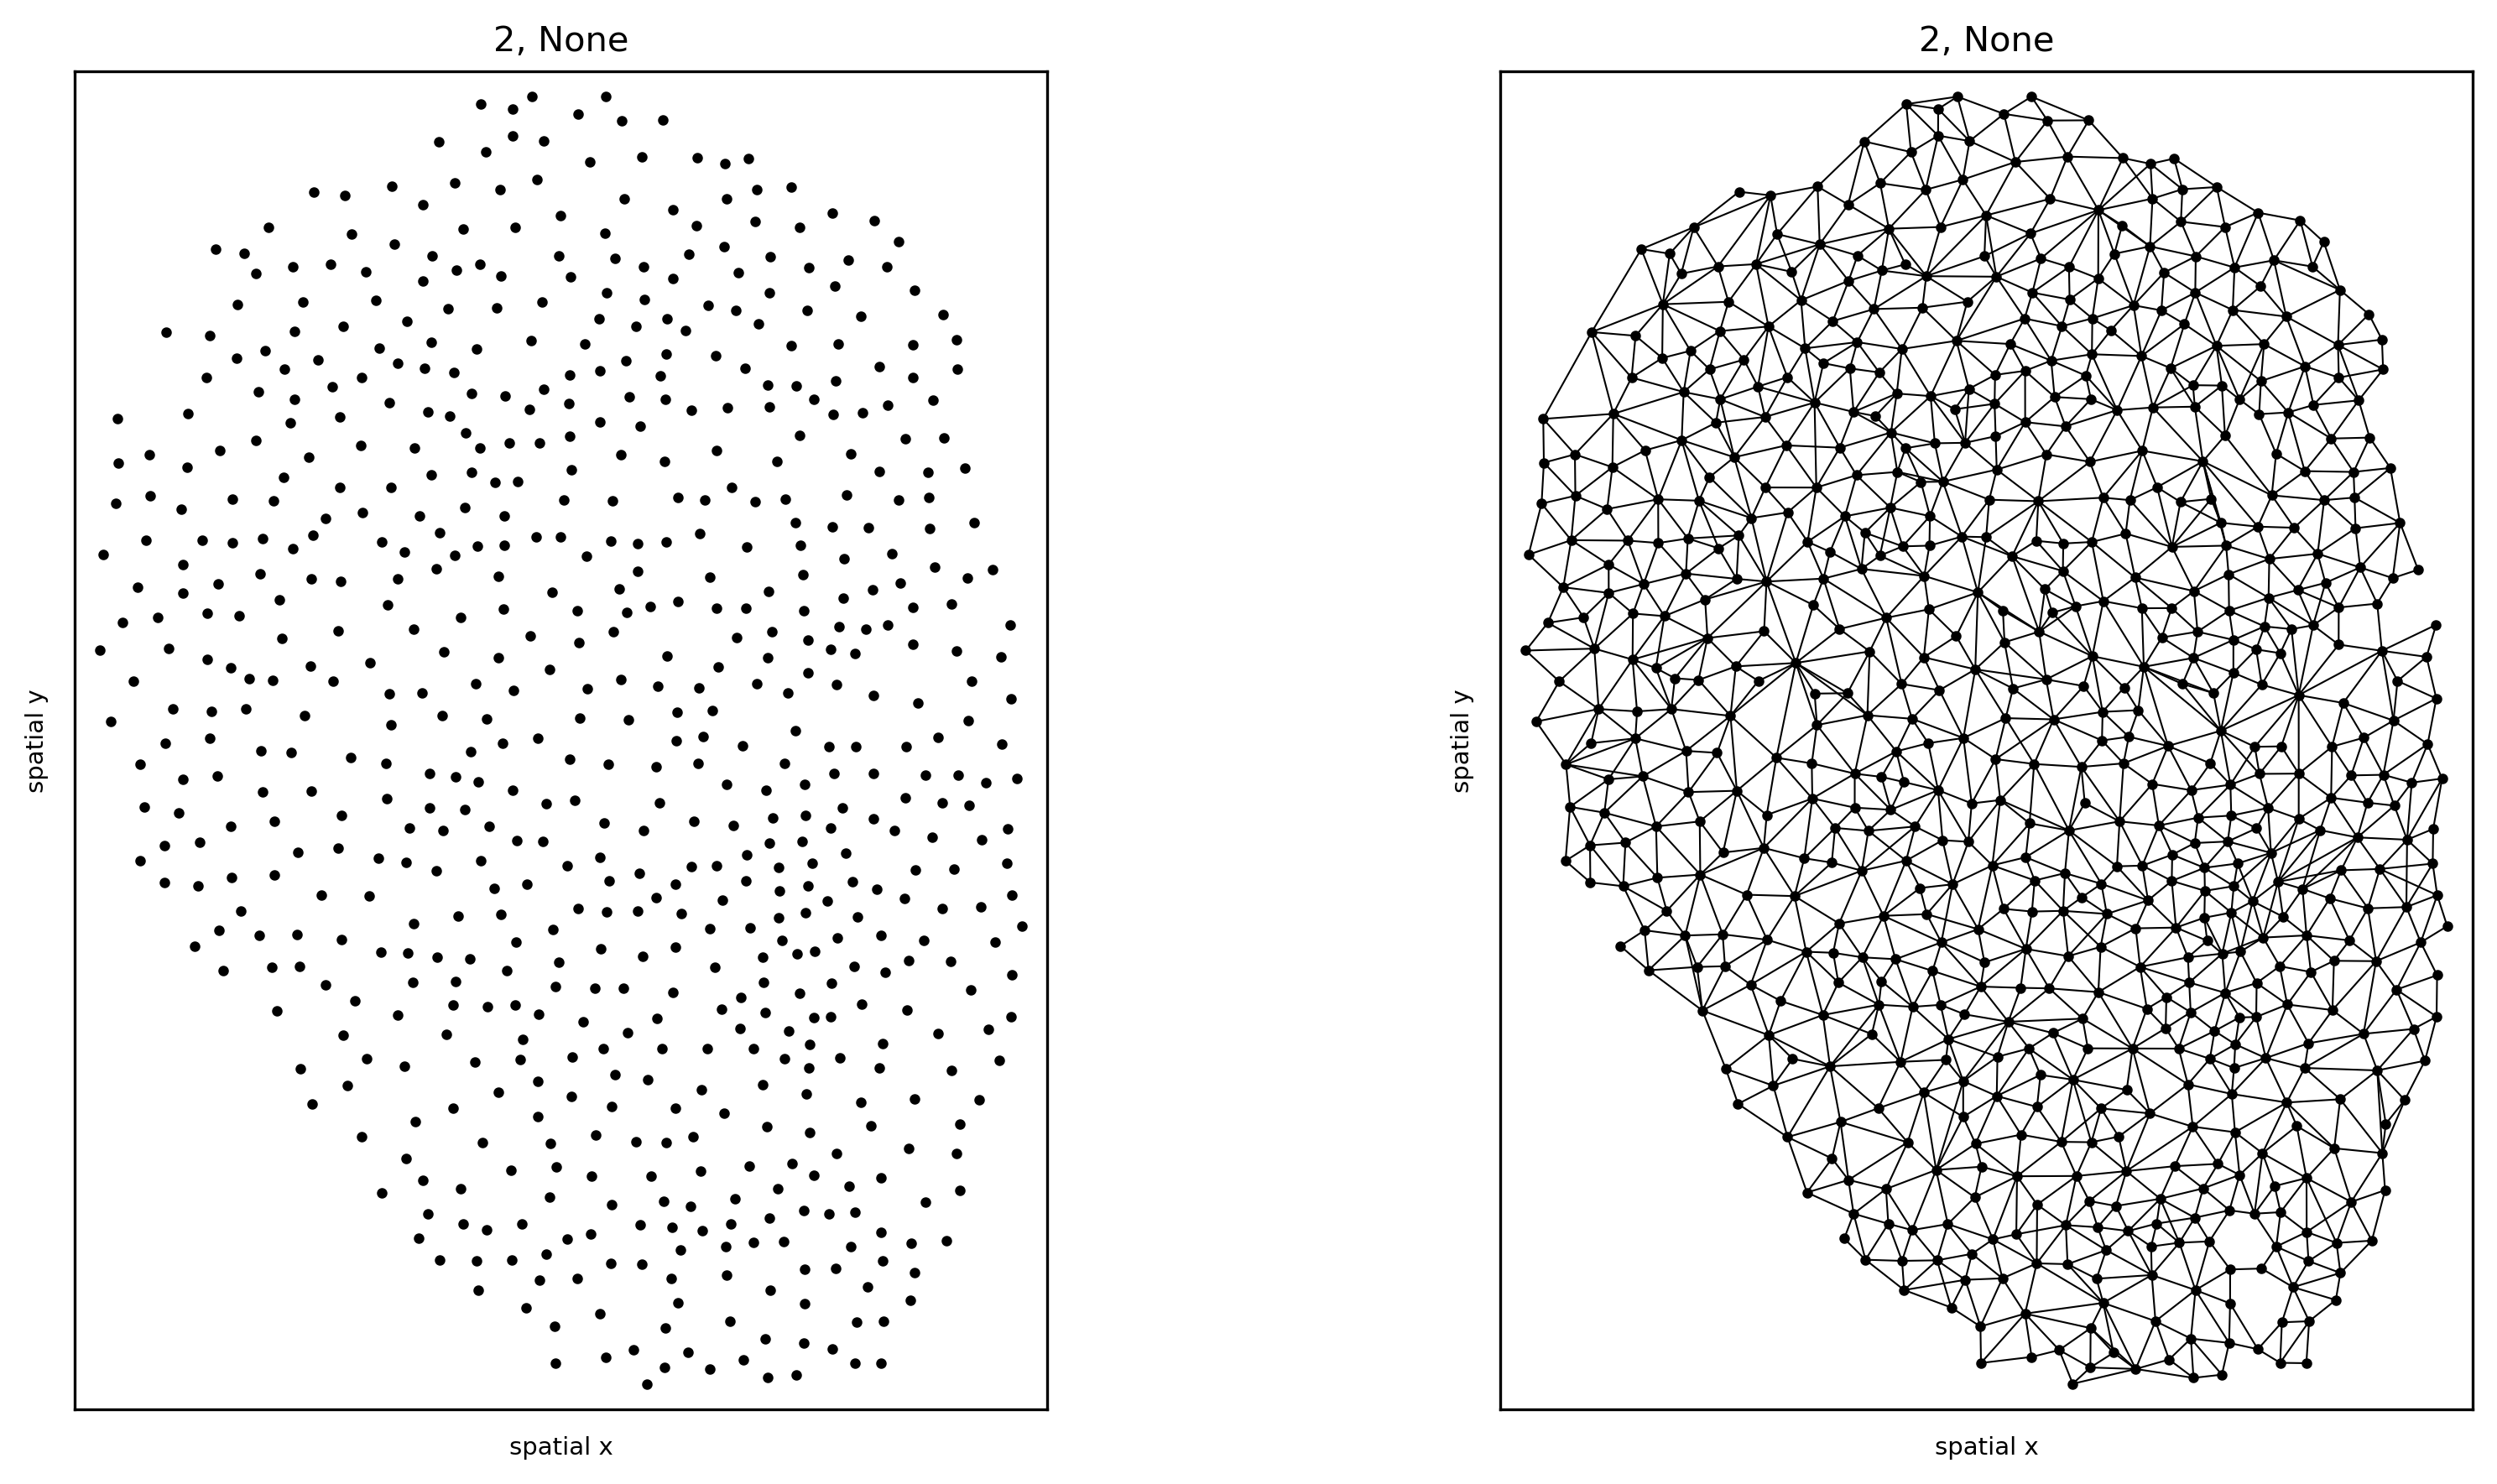

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
ath.pl.spatial(spadata, foll, None, ax=axs.flat[0])
ath.pl.spatial(spadata, foll, None, edges=True, graph_key='contact', ax=axs.flat[1])